## Load results for each method

In [1]:
import pandas as pd

# Clear previous results
df_cot = []
df_cove = []
df_self_refine = []

# Load results
# df_cot = pd.read_csv("results/cot_few-shot/cot_few-shot_results_2025-03-27_13-55-58.csv")
# df_cove = pd.read_csv("results/cove_few-shot/cove_few-shot_results_2025-03-27_14-42-13.csv")
# df_self_refine = pd.read_csv("results/self-refine_few-shot/self-refine_few-shot_results_2025-03-27_15-08-17.csv")

df_cot = pd.read_csv("results/cot_few-shot/cot_few-shot_results_2025-03-28_11-16-41.csv")
df_cove = pd.read_csv("results/cove_few-shot/cove_few-shot_results_2025-03-28_12-04-04.csv")
df_self_refine = pd.read_csv("results/self-refine_few-shot/self-refine_few-shot_results_2025-03-28_12-33-28.csv")

### Rename columns before merging

In [2]:
df_cot = df_cot.rename(columns={"predicted": "predicted_cot"})
df_cove = df_cove.rename(columns={"predicted": "predicted_cove"})
df_self_refine = df_self_refine.rename(columns={"predicted": "predicted_sr"})

#### Translate Subjects to English

In [3]:
subject_translation = {
    "Matemática e suas Tecnologias": "Mathematics",
    "Linguagens, Códigos e suas Tecnologias": "Languages",
    "Ciências Humanas e suas Tecnologias": "Human Sciences",
    "Ciências da Natureza e suas Tecnologias": "Natural Sciences"
}

df_cot["subject"] = df_cot["subject"].map(subject_translation)
df_cove["subject"] = df_cove["subject"].map(subject_translation)
df_self_refine["subject"] = df_self_refine["subject"].map(subject_translation)

### Merge results on question ID

In [4]:
df_all = df_cot[["id", "subject", "ground_truth", "predicted_cot"]].merge(
    df_cove[["id", "predicted_cove"]],
    on="id"
).merge(
    df_self_refine[["id", "predicted_sr"]],
    on="id"
)

## Calculate Accuracy

### Add correctness flags for each method

In [5]:
df_all["correct_cot"] = df_all["predicted_cot"] == df_all["ground_truth"]
df_all["correct_cove"] = df_all["predicted_cove"] == df_all["ground_truth"]
df_all["correct_sr"] = df_all["predicted_sr"] == df_all["ground_truth"]

### Calculate accuracy for each method

In [6]:
# Calculate subject-wise accuracy
subject_acc = (
    df_all.groupby("subject")[["correct_cot", "correct_cove", "correct_sr"]]
    .mean()
    .round(3)
    .rename(columns={
        "correct_cot": "CoT",
        "correct_cove": "CoVe",
        "correct_sr": "Self-Refine"
    })
)

# Calculate general accuracy
general_accuracy = df_all[["correct_cot", "correct_cove", "correct_sr"]].mean().round(3)
general_accuracy.index = ["CoT", "CoVe", "Self-Refine"]

# Append general accuracy as a new row
subject_acc.loc["General Accuracy"] = general_accuracy

display(subject_acc)

,CoT,CoVe,Self-Refine
subject,,,
Human Sciences,0.978,0.911,0.933
Languages,0.756,0.844,0.800
Mathematics,0.422,0.378,0.511
Natural Sciences,0.533,0.556,0.556
General Accuracy,0.672,0.672,0.700


### Visualize Accuracy per Subject

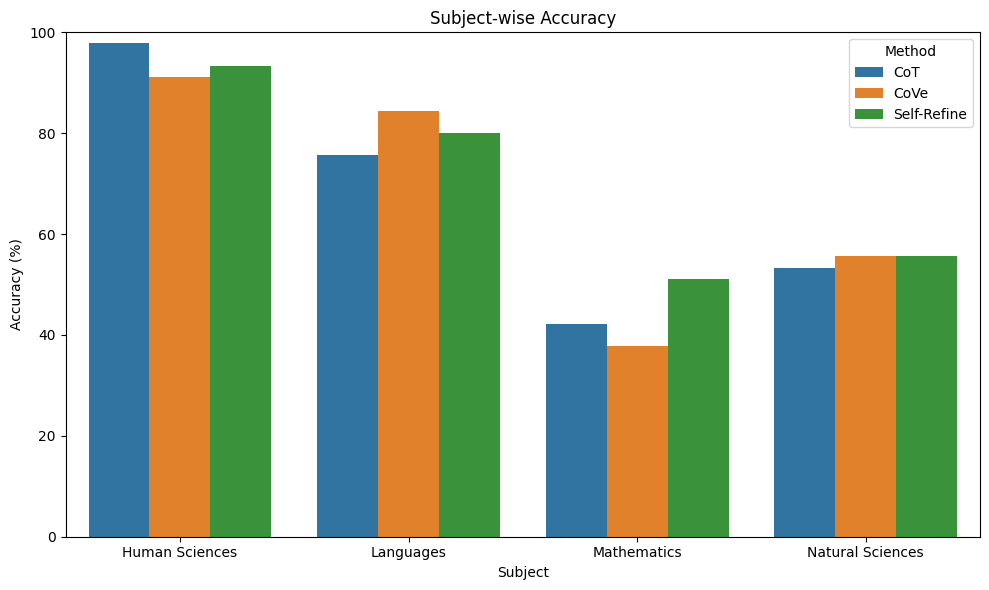

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the general accuracy row for subject-wise plot
plot_df = subject_acc.drop("General Accuracy").reset_index().melt(
    id_vars="subject", var_name="Method", value_name="Accuracy"
)

# Convert to percentage
plot_df["Accuracy"] *= 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x="subject", y="Accuracy", hue="Method")

plt.title("Subject-wise Accuracy")
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.xlabel("Subject")
plt.legend(title="Method")
plt.tight_layout()
plt.show()

## Analyse effects of feedback iterations

### CoVe

#### Define regressions, improvements and neutral changes

Model changed answer after feedback, ...

**Improvement**: Initial answer was wrong, final answer was correct

**Regression**: Initial answer was correct, final answer was wrong

**Neutral**: Nor initial nor final answer were correct

In [8]:
# Define if the answer changed
df_cove["changed_initial_answer"] = (
    df_cove["initial_answer"] != df_cove["predicted_cove"]
)

# Initialize flags
df_cove["improvement"] = False
df_cove["regression"] = False
df_cove["neutral_change"] = False

# Assign improvement: changed → became correct
df_cove.loc[
    df_cove["changed_initial_answer"] &
    (df_cove["initial_answer"] != df_cove["ground_truth"]) &
    (df_cove["predicted_cove"] == df_cove["ground_truth"]),
    "improvement"
] = True

# Assign regression: changed → became wrong (was correct initially)
df_cove.loc[
    df_cove["changed_initial_answer"] &
    ~df_cove["improvement"] &
    (df_cove["initial_answer"] == df_cove["ground_truth"]) &
    (df_cove["predicted_cove"] != df_cove["ground_truth"]),
    "regression"
] = True

# Assign neutral: changed → still wrong, and initial wasn't correct either
df_cove.loc[
    df_cove["changed_initial_answer"] &
    ~df_cove["improvement"] &
    ~df_cove["regression"] &
    (df_cove["initial_answer"] != df_cove["ground_truth"]) &
    (df_cove["predicted_cove"] != df_cove["ground_truth"]),
    "neutral_change"
] = True


In [9]:
subject_summary_cove = df_cove.groupby("subject").agg(
    total_questions=("id", "count"),
    changes=("changed_initial_answer", "sum"),
    neutral_change=("neutral_change", "sum"),
    regressions=("regression", "sum"),
    improvements=("improvement", "sum")
).reset_index()

display(subject_summary_cove)

,subject,total_questions,changes,neutral_change,regressions,improvements
0,Human Sciences,45,0,0,0,0
1,Languages,45,1,1,0,0
2,Mathematics,45,11,8,3,0
3,Natural Sciences,45,3,2,1,0


#### 📊 CoVe – Regressions, Improvements and Neutral Changes per Subject

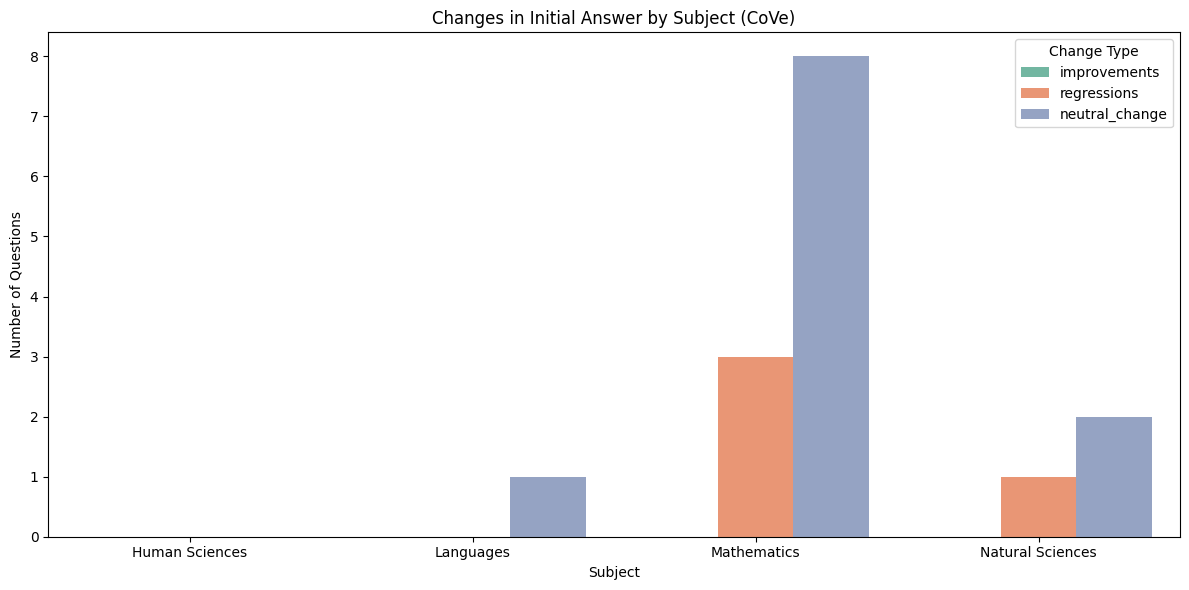

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape to long format
subject_summary_long = subject_summary_cove.melt(
    id_vars="subject",
    value_vars=["improvements", "regressions", "neutral_change"],
    var_name="Change Type",
    value_name="Count"
)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=subject_summary_long,
    x="subject",
    y="Count",
    hue="Change Type",
    palette="Set2"
)

plt.title("Changes in Initial Answer by Subject (CoVe)")
plt.ylabel("Number of Questions")
plt.xlabel("Subject")
plt.tight_layout()
plt.show()

#### 📊 CoVe – Changed vs Unchanged Initial Answer

In [13]:
df_cove["correct"] = df_cove["predicted_cove"] == df_cove["ground_truth"]

subject_accuracy_cove = (
    df_cove
    .groupby(["subject", "changed_initial_answer"])["correct"]
    .mean()
    .reset_index()
)

# Optional renaming
subject_accuracy_cove["changed_initial_answer"] = subject_accuracy_cove["changed_initial_answer"].map({
    True: "Changed",
    False: "Unchanged"
})
subject_accuracy_cove.rename(columns={"correct": "Accuracy"}, inplace=True)

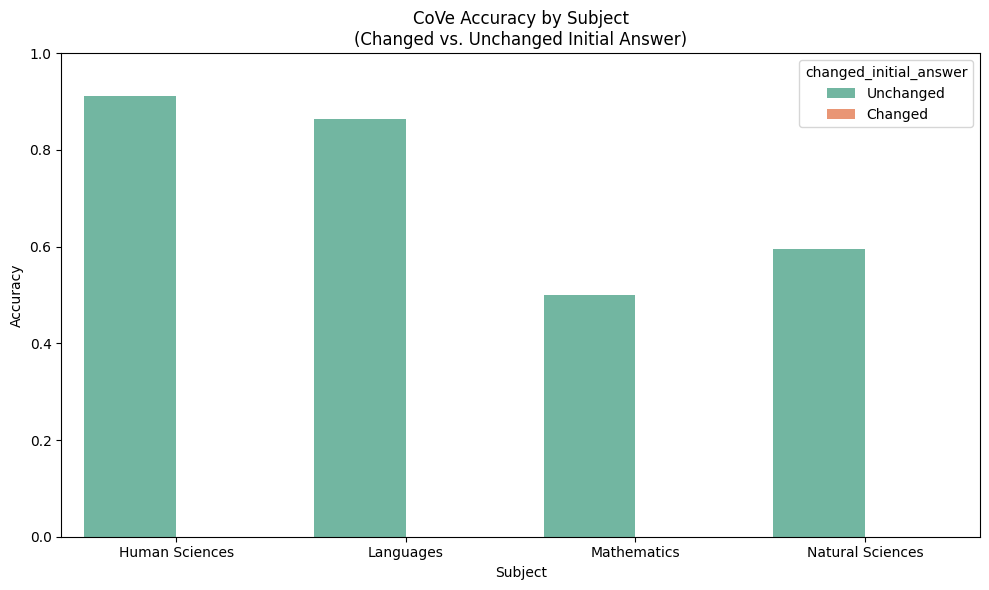

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=subject_accuracy_cove,
    x="subject",
    y="Accuracy",
    hue="changed_initial_answer",
    palette="Set2"
)

plt.title("CoVe Accuracy by Subject\n(Changed vs. Unchanged Initial Answer)")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xlabel("Subject")
plt.tight_layout()
plt.show()

#### Compare initial vs final answer

In [43]:
df_cove["initial_correct"] = df_cove["initial_answer"] == df_cove["ground_truth"]
df_cove["final_correct"] = df_cove["predicted_cove"] == df_cove["ground_truth"]


In [44]:
subject_acc_cove = (
    df_cove
    .groupby("subject")[["initial_correct", "final_correct"]]
    .mean()
    .reset_index()
)

In [45]:
subject_acc_long = subject_acc_cove.melt(
    id_vars="subject",
    value_vars=["initial_correct", "final_correct"],
    var_name="Answer Version",
    value_name="Accuracy"
)

subject_acc_long["Answer Version"] = subject_acc_long["Answer Version"].map({
    "initial_correct": "Initial Answer",
    "final_correct": "Final Answer"
})


#### 📊 CoVe – Initial vs Final Answer Accuracy

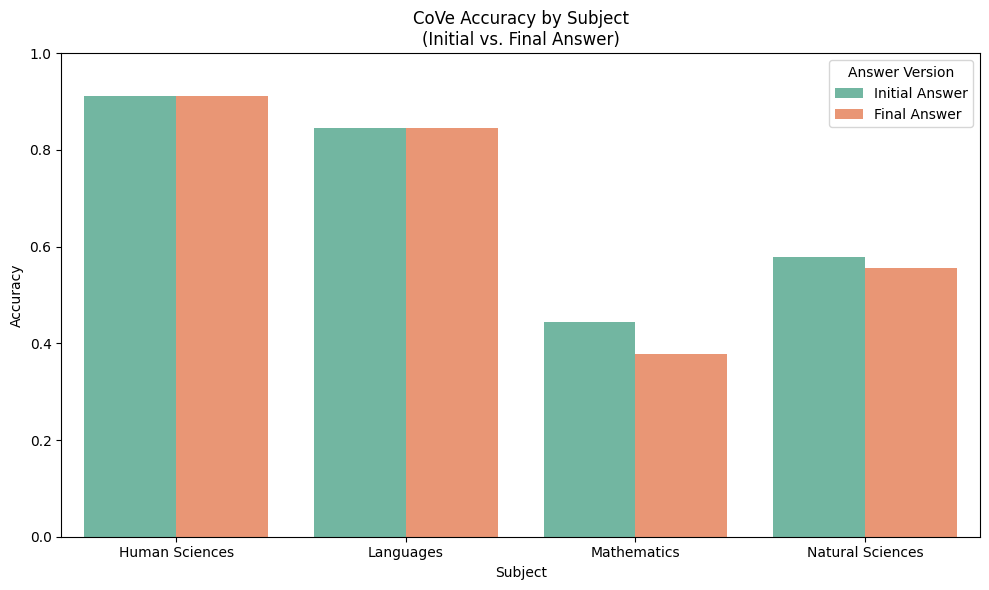

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=subject_acc_long,
    x="subject",
    y="Accuracy",
    hue="Answer Version",
    palette="Set2"
)

plt.title("CoVe Accuracy by Subject\n(Initial vs. Final Answer)")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xlabel("Subject")
plt.tight_layout()
plt.show()

### Self-Refine

#### Extract and normalize answers

In [16]:
import ast

# Normalize the full answer sequence
df_self_refine["answer_sequence_normalized"] = df_self_refine["answer_sequence"].apply(
    lambda seq: [str(a).strip().upper() for a in ast.literal_eval(seq)] if pd.notnull(seq) else []
)

# Extract the first answer (normalized)
df_self_refine["initial_answer"] = df_self_refine["answer_sequence_normalized"].apply(
    lambda seq: seq[0] if len(seq) > 0 else None
)

# Normalize ground truth and predicted answers
df_self_refine["ground_truth_normalized"] = df_self_refine["ground_truth"].str.strip().str.upper()
df_self_refine["predicted_normalized"] = df_self_refine["predicted_sr"].str.strip().str.upper()

# Drop original (raw) columns for clarity
df_self_refine.drop(columns=["answer_sequence", "ground_truth", "predicted_sr"], inplace=True)

#### Define regressions, improvements and neutral changes

**Improvement**: Initial answer was wrong, final answer was right

**Regression**: Correct answer is present in the answer sequence, but the final answer is wrong

**Neutral**: Correct answer is not present in the answer sequence


In [17]:
# Define if the answer changed
df_self_refine["changed_initial_answer"] = (
    df_self_refine["initial_answer"] != df_self_refine["predicted_normalized"]
)

# Initialize flags
df_self_refine["improvement"] = False
df_self_refine["regression"] = False
df_self_refine["neutral_change"] = False

# Assign improvement: changed → became correct
df_self_refine.loc[
    df_self_refine["changed_initial_answer"] &
    (df_self_refine["initial_answer"] != df_self_refine["ground_truth_normalized"]) &
    (df_self_refine["predicted_normalized"] == df_self_refine["ground_truth_normalized"]),
    "improvement"
] = True

# Assign regression: changed → final answer is wrong, but ground truth appeared earlier
df_self_refine.loc[
    df_self_refine["changed_initial_answer"] &
    ~df_self_refine["improvement"] &  # ensure exclusivity
    df_self_refine.apply(
        lambda row: row["ground_truth_normalized"] in row["answer_sequence_normalized"]
        and row["predicted_normalized"] != row["ground_truth_normalized"],
        axis=1
    ),
    "regression"
] = True

# Assign neutral_change: changed → final is wrong and ground truth never seen
df_self_refine.loc[
    df_self_refine["changed_initial_answer"] &
    ~df_self_refine["improvement"] &
    ~df_self_refine["regression"] &
    (df_self_refine["predicted_normalized"] != df_self_refine["ground_truth_normalized"]) &
    (~df_self_refine.apply(
        lambda row: row["ground_truth_normalized"] in row["answer_sequence_normalized"],
        axis=1
    )),
    "neutral_change"
] = True


##### Calculate number of feedback iterations per question

In [18]:
# Recalculate initial answer directly from the parsed, normalized list
df_self_refine["initial_answer"] = df_self_refine["answer_sequence_normalized"].apply(
    lambda seq: seq[0] if isinstance(seq, list) and len(seq) > 0 else None
)

# Number of iterations is the length of the parsed, normalized sequence
df_self_refine["feedback_iterations"] = df_self_refine["answer_sequence_normalized"].apply(
    lambda seq: len(seq) if isinstance(seq, list) else 0
)

##### Checkout cases where the model changed its initial answer

In [19]:
df_self_refine[df_self_refine["changed_initial_answer"]][
    ["id", "ground_truth_normalized",  "predicted_normalized", "initial_answer", "answer_sequence_normalized", "improvement", "regression", "neutral_change"]
]

,id,ground_truth_normalized,predicted_normalized,initial_answer,answer_sequence_normalized,improvement,regression,neutral_change
3,questao_04,E,E,D,"[D, E]",True,False,False
16,questao_17,B,A,B,"[B, E, B, A]",False,True,False
20,questao_21,C,E,D,"[D, E]",False,False,True
27,questao_28,B,B,E,"[E, B]",True,False,False
28,questao_29,A,A,D,"[D, A]",True,False,False
30,questao_31,D,A,D,"[D, A]",False,True,False
53,questao_54,D,B,D,"[D, B]",False,True,False
55,questao_56,A,A,E,"[E, A, E, A]",True,False,False
77,questao_78,A,A,D,"[D, A]",True,False,False
88,questao_89,C,E,C,"[C, B, C, E]",False,True,False


In [20]:
subject_summary_sr = df_self_refine.groupby("subject").agg(
    total_questions=("id", "count"),
    changes=("changed_initial_answer", "sum"),
    regressions=("regression", "sum"),
    improvements=("improvement", "sum"),
    neutral_changes=("neutral_change", "sum"),
).reset_index()

display(subject_summary_sr)

,subject,total_questions,changes,regressions,improvements,neutral_changes
0,Human Sciences,45,4,2,2,0
1,Languages,45,6,2,3,1
2,Mathematics,45,9,6,1,2
3,Natural Sciences,45,11,5,4,2


#### 📊 Self-Refine – Regressions, Improvements and Neutral Changes per Subject

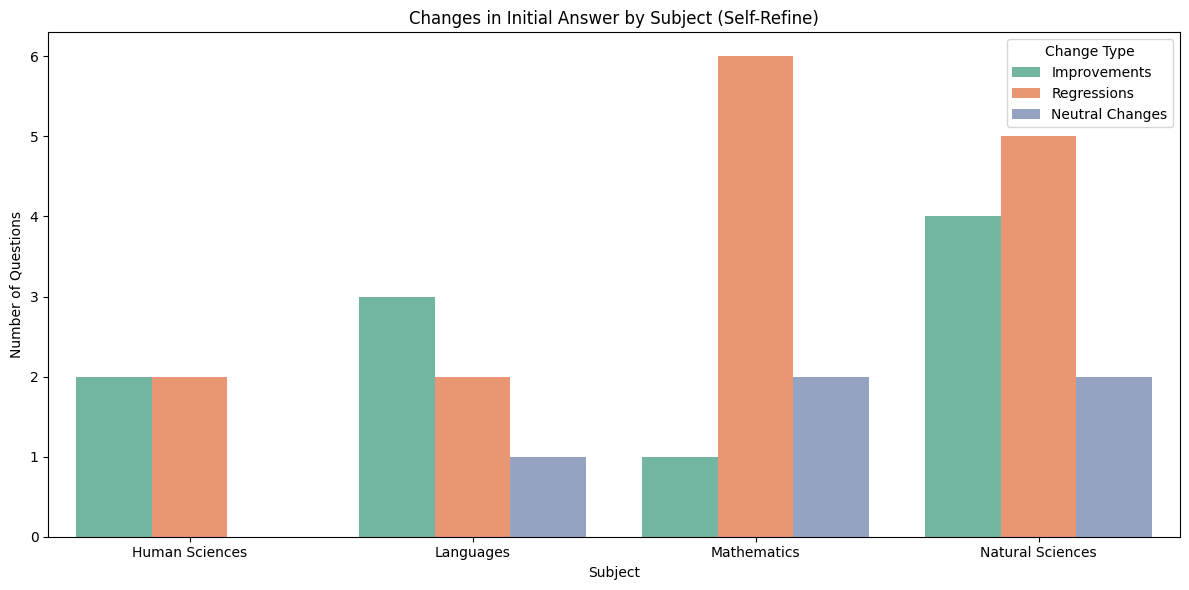

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape from wide to long format
subject_long = subject_summary_sr.melt(
    id_vars="subject",
    value_vars=["improvements", "regressions", "neutral_changes"],
    var_name="Change Type",
    value_name="Count"
)

# Capitalize labels for display
subject_long["Change Type"] = subject_long["Change Type"].str.replace("_", " ").str.title()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=subject_long,
    x="subject",
    y="Count",
    hue="Change Type",
    palette="Set2"
)

plt.title("Changes in Initial Answer by Subject (Self-Refine)")
plt.ylabel("Number of Questions")
plt.xlabel("Subject")
plt.tight_layout()
plt.show()

##### Checkout where model had several feedback iterations and came back to initial answer

In [24]:
df_self_refine[
    (df_self_refine["feedback_iterations"] > 1) &
    (df_self_refine["initial_answer"] == df_self_refine["predicted_normalized"])
][[
    "id",
    "ground_truth_normalized",
    "initial_answer",
    "predicted_normalized",
    "answer_sequence_normalized",
    "feedback_iterations",
    "improvement",
    "regression"
]]

,id,ground_truth_normalized,initial_answer,predicted_normalized,answer_sequence_normalized,feedback_iterations,improvement,regression
97,questao_98,B,B,B,"[B, E, B]",3,False,False
108,questao_109,D,D,D,"[D, E, D]",3,False,False
117,questao_118,E,B,B,"[B, E, A, B]",4,False,False
153,questao_154,A,D,D,"[D, B, A, D]",4,False,False
156,questao_157,C,C,C,"[C, A, C]",3,False,False
166,questao_167,A,A,A,"[A, C, A]",3,False,False


In [25]:
df_self_refine["correct_final"] = (
    df_self_refine["predicted_normalized"] == df_self_refine["ground_truth_normalized"]
)
unchanged_final = df_self_refine[
    (df_self_refine["feedback_iterations"] > 1) &
    (df_self_refine["initial_answer"] == df_self_refine["predicted_normalized"])
]

unchanged_summary = unchanged_final["correct_final"].value_counts().rename_axis("Final Answer Correct").reset_index(name="Count")
unchanged_summary["Final Answer Correct"] = unchanged_summary["Final Answer Correct"].map({True: "Correct", False: "Incorrect"})


#### 📊 Self-Refine – Effect of returning to initial answer after feedback rounds

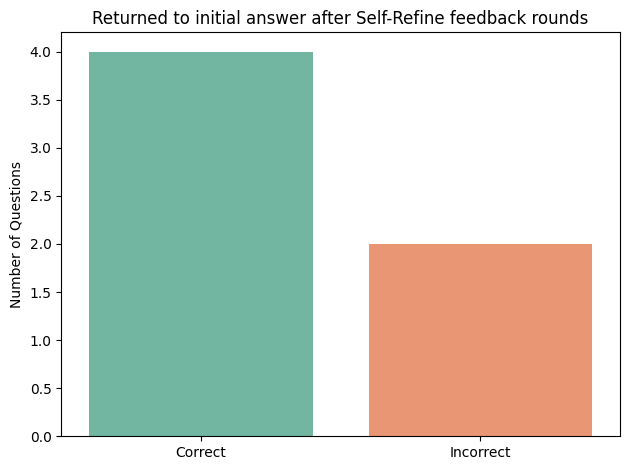

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    data=unchanged_summary,
    x="Final Answer Correct",
    y="Count",
    hue="Final Answer Correct",
    palette="Set2",
    legend=False
)
plt.title("Returned to initial answer after Self-Refine feedback rounds")
plt.ylabel("Number of Questions")
plt.xlabel("")
plt.tight_layout()
plt.show()


#### 📊 Self-Refine – Changed vs Unchanged Initial Answer

In [29]:
subject_accuracy_change = (
    df_self_refine
    .groupby(["subject", "changed_initial_answer"])["correct"]
    .mean()
    .reset_index()
)

# Rename for clarity
subject_accuracy_change["changed_initial_answer"] = subject_accuracy_change["changed_initial_answer"].map({
    True: "Changed",
    False: "Unchanged"
})
subject_accuracy_change.rename(columns={"correct": "Accuracy"}, inplace=True)

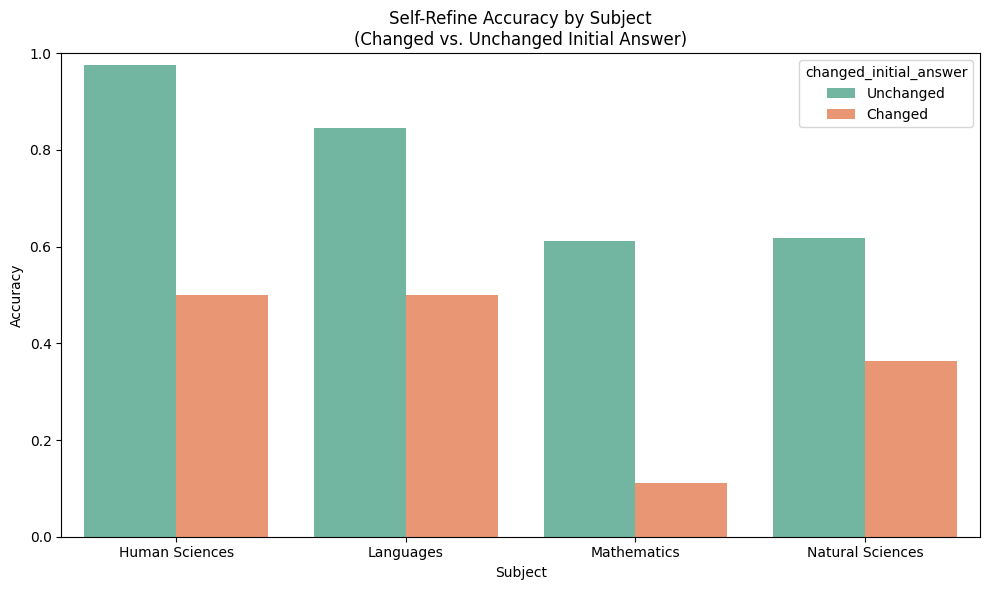

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=subject_accuracy_change,
    x="subject",
    y="Accuracy",
    hue="changed_initial_answer",
    palette="Set2"
)

plt.title("Self-Refine Accuracy by Subject\n(Changed vs. Unchanged Initial Answer)")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xlabel("Subject")
plt.tight_layout()
plt.show()

#### Compare initial and final answers

In [38]:
df_self_refine["initial_correct"] = (
    df_self_refine["initial_answer"] == df_self_refine["ground_truth_normalized"]
)

df_self_refine["final_correct"] = (
    df_self_refine["predicted_normalized"] == df_self_refine["ground_truth_normalized"]
)

In [39]:
subject_initial_vs_final = (
    df_self_refine
    .groupby("subject")[["initial_correct", "final_correct"]]
    .mean()
    .reset_index()
)

In [40]:
subject_long = subject_initial_vs_final.melt(
    id_vars="subject",
    var_name="Answer Version",
    value_name="Accuracy"
)

# Rename for better labels
subject_long["Answer Version"] = subject_long["Answer Version"].map({
    "initial_correct": "Initial Answer",
    "final_correct": "Final Answer"
})


#### 📊 Self-Refine – Initial vs Final Answer Accuracy

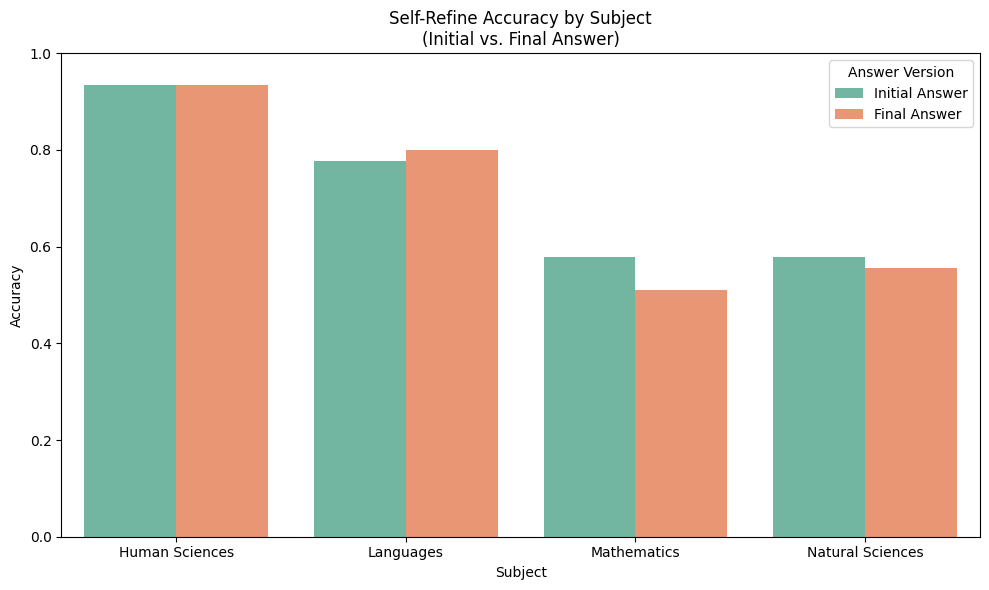

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=subject_long,
    x="subject",
    y="Accuracy",
    hue="Answer Version",
    palette="Set2"
)

plt.title("Self-Refine Accuracy by Subject\n(Initial vs. Final Answer)")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xlabel("Subject")
plt.tight_layout()
plt.show()

### Compare CoVe and Self-Refine

#### Did they improve or regress on the same questions?

## Compare initial answers from all methods